In [1]:
from typing import Dict, Callable, Optional, Tuple
import jraph
import jax
import jax.numpy as jnp
import e3nn_jax as e3nn
import nequip_jax
import numpy as np
import optax
import haiku as hk
import chex
from clu import parameter_overview
import ml_collections

import matplotlib.pyplot as plt
import seaborn as sns

from absl import logging
logging.set_verbosity(logging.DEBUG)


In [2]:
config = ml_collections.ConfigDict()
config.molecule = "uracil"
config.batch_size = 32
config.num_train_steps = 10000
config.num_test_steps = 100
config.train_fraction = 0.001
config.test_fraction = 0.001
config.nn_cutoff = 1.5
config.max_ell = 3
config.num_channels = 16
config.num_interactions = 3

In [3]:
# Data stuff

def create_graphstuples(
    molecules: Dict[str, np.ndarray], num_steps: int, batch_size: int, nn_cutoff: float, rng: chex.PRNGKey
):
    """Creates batches of graphs from a molecule dictionary."""
    num_samples, num_atoms, _ = molecules["R"].shape

    # Compute the distance matrix to select the edges.
    positions = molecules["R"][0]
    distance_matrix = jnp.linalg.norm(
        positions[None, :, :] - positions[:, None, :], axis=-1
    )

    # Avoid self-edges.
    valid_edges = (distance_matrix > 0) & (distance_matrix <= nn_cutoff)
    senders, receivers = np.nonzero(valid_edges)
    n_edge = jnp.asarray([valid_edges.sum()])
    n_node = jnp.asarray([num_atoms])

    # Embed species as one-hot vectors.
    species = molecules["z"]
    species_encoder = {
        1: 0,
        6: 1,
        7: 2,
        8: 3,
        9: 4,
    }
    species = jnp.asarray([species_encoder[int(s)] for s in species])
    del molecules["z"]

    graphs = []
    for step in range(num_steps * batch_size):
        step = step % num_samples
        rng, step_rng = jax.random.split(rng)

        # Create a graph from the molecule data.
        graph = jraph.GraphsTuple(
            nodes={
                "positions": molecules["R"][step],
                "forces": molecules["F"][step],
                "species": species,
            },
            edges=None,
            globals=None,
            senders=senders,
            receivers=receivers,
            n_node=n_node,
            n_edge=n_edge,
        )
        graphs.append(graph)

        if step % batch_size == (batch_size - 1):
            yield jraph.batch(graphs)

            # Reset the list of graphs.
            # Permute the molecules to create a new batch.
            graphs = []
            permutation = jax.random.permutation(step_rng, num_samples)
            molecules = {
                "R": molecules["R"][permutation],
                "F": molecules["F"][permutation],
            }


def get_datasets(
    config: ml_collections.ConfigDict,
    rng: chex.PRNGKey,
):
    """Creates train and test datasets for a given molecule."""
    molecule = config.molecule
    batch_size = config.batch_size
    nn_cutoff = config.nn_cutoff
    train_fraction = config.train_fraction
    test_fraction = config.test_fraction
    num_train_steps = config.num_train_steps
    num_test_steps = config.num_test_steps

    # Load the molecule data, and split into train and test.
    molecules = np.load(f"data/md17_{molecule}.npz")
    molecules = {
        "R": molecules["R"],
        "z": molecules["z"],
        "F": molecules["F"],
    }
    num_molecules = molecules["R"].shape[0]
    num_train_samples = int(num_molecules * train_fraction)
    num_test_samples = int(num_molecules * test_fraction)
    
    logging.info("Number of training samples: %d", num_train_samples)
    logging.info("Number of test samples: %d", num_test_samples)

    train_rng, test_rng = jax.random.split(rng)
    train_molecules = jax.tree_map(lambda x: x[:num_train_samples], molecules)
    test_molecules = jax.tree_map(lambda x: x[-num_test_samples:], molecules)
    datasets = {
        "train": create_graphstuples(
            train_molecules, num_train_steps, batch_size, nn_cutoff, train_rng
        ),
        "test": create_graphstuples(
            test_molecules, num_test_steps, batch_size, nn_cutoff, test_rng
        ),
    }
    return datasets

In [4]:
# Model stuff
class NequIP(hk.Module):
    """Wrapper class for NequIP."""

    def __init__(
        self,
        num_species: int,
        r_max: float,
        avg_num_neighbors: float,
        max_ell: int,
        init_embedding_dims: int,
        hidden_irreps: str,
        output_irreps: str,
        num_interactions: int,
        even_activation: Callable[[jnp.ndarray], jnp.ndarray],
        odd_activation: Callable[[jnp.ndarray], jnp.ndarray],
        mlp_activation: Callable[[jnp.ndarray], jnp.ndarray],
        mlp_n_hidden: int,
        mlp_n_layers: int,
        n_radial_basis: int,
        skip_connection: bool,
        name: Optional[str] = None,
    ):
        super().__init__(name=name)
        self.num_species = num_species
        self.r_max = r_max
        self.avg_num_neighbors = avg_num_neighbors
        self.max_ell = max_ell
        self.init_embedding_dims = init_embedding_dims
        self.hidden_irreps = hidden_irreps
        self.output_irreps = output_irreps
        self.num_interactions = num_interactions
        self.even_activation = even_activation
        self.odd_activation = odd_activation
        self.mlp_activation = mlp_activation
        self.mlp_n_hidden = mlp_n_hidden
        self.mlp_n_layers = mlp_n_layers
        self.n_radial_basis = n_radial_basis
        self.skip_connection = skip_connection

    def __call__(
        self,
        graphs: jraph.GraphsTuple,
    ):
        positions = graphs.nodes["positions"]
        relative_positions = (
            positions[graphs.receivers]
            - positions[graphs.senders]
        )
        relative_positions = relative_positions / self.r_max
        relative_positions = e3nn.IrrepsArray("1o", relative_positions)

        species = graphs.nodes["species"]
        node_feats = hk.Embed(self.num_species, self.init_embedding_dims)(species)
        node_feats = e3nn.IrrepsArray(f"{node_feats.shape[1]}x0e", node_feats)

        for interaction in range(self.num_interactions):
            new_node_feats = nequip_jax.NEQUIPESCNLayerHaiku(
                avg_num_neighbors=self.avg_num_neighbors,
                num_species=self.num_species,
                output_irreps=self.hidden_irreps,
                even_activation=self.even_activation,
                odd_activation=self.odd_activation,
                mlp_activation=self.mlp_activation,
                mlp_n_hidden=self.mlp_n_hidden,
                mlp_n_layers=self.mlp_n_layers,
                n_radial_basis=self.n_radial_basis,
            )(relative_positions, node_feats, species, graphs.senders, graphs.receivers)
            new_node_feats = e3nn.haiku.Linear(
                irreps_out=self.hidden_irreps, force_irreps_out=True
            )(new_node_feats)

            if self.skip_connection and interaction > 0:
                new_node_feats += node_feats
            node_feats = new_node_feats

        # Final linear layer
        node_feats = e3nn.haiku.Linear(
                irreps_out=self.output_irreps, force_irreps_out=True
        )(node_feats)
        return node_feats

In [5]:
@hk.without_apply_rng
@hk.transform
def model(graphs):
    net = NequIP(
        num_species = 5,
        r_max = config.nn_cutoff,
        avg_num_neighbors = 100.,
        max_ell = config.max_ell,
        init_embedding_dims = config.num_channels,
        hidden_irreps= config.num_channels * e3nn.s2_irreps(config.max_ell),
        output_irreps = "1o",
        num_interactions = config.num_interactions,
        even_activation = jax.nn.swish,
        odd_activation = jax.nn.tanh,
        mlp_activation = jax.nn.swish,
        mlp_n_hidden = 64,
        mlp_n_layers = 2,
        n_radial_basis = 8,
        skip_connection = False,
    )
    return net(graphs)

In [6]:
rng = jax.random.PRNGKey(0)
rng, dataset_rng = jax.random.split(rng)
datasets = get_datasets(config, dataset_rng)


# Initialize the model.
rng, init_rng = jax.random.split(rng)
example_graphs = next(iter(datasets["train"]))
params = model.init(init_rng, example_graphs)
parameter_overview.log_parameter_overview(params)

INFO:absl:Number of training samples: 133
INFO:absl:Number of test samples: 133
INFO:absl:
+--------------------------------------------------------------------+-------------+--------+----------+-------+
| Name                                                               | Shape       | Size   | Mean     | Std   |
+--------------------------------------------------------------------+-------------+--------+----------+-------+
| nequ_ip/embed/embeddings                                           | (5, 16)     | 80     | -0.0879  | 0.937 |
| nequ_ip/linear/w[0,0] 16x0e,16x0e                                  | (16, 16)    | 256    | -0.0375  | 1.01  |
| nequ_ip/linear/w[1,1] 16x1o,16x1o                                  | (16, 16)    | 256    | -0.101   | 0.996 |
| nequ_ip/linear/w[2,2] 16x2e,16x2e                                  | (16, 16)    | 256    | 0.00831  | 0.954 |
| nequ_ip/linear/w[3,3] 16x3o,16x3o                                  | (16, 16)    | 256    | 0.0509   | 0.95  |
| neq

In [7]:
# Initialize optimizer
tx = optax.adam(1e-3)
opt_state = tx.init(params)

In [8]:
@jax.jit
def train_step(graphs: jraph.GraphsTuple, params: optax.Params, opt_state: optax.OptState):
    def loss_fn(params):
        predicted_forces = model.apply(params, graphs).array
        return optax.l2_loss(predicted_forces, graphs.nodes["forces"]).sum(axis=-1).mean()
    
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grad = grad_fn(params)
    updates, opt_state = tx.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [9]:
losses = []
steps = []

for step, graphs in enumerate(datasets["train"]):
    params, opt_state, loss = train_step(graphs, params, opt_state)
    if step % 100 == 0:
        print(f"Step {step} loss {loss:.2f}")
        losses.append(loss)
        steps.append(step)

Step 0 loss 1047.24
Step 100 loss 717.55
Step 200 loss 541.08
Step 300 loss 404.07
Step 400 loss 403.14
Step 500 loss 372.49
Step 600 loss 360.24
Step 700 loss 340.75
Step 800 loss 286.43
Step 900 loss 277.84
Step 1000 loss 274.89
Step 1100 loss 242.58
Step 1200 loss 251.14
Step 1300 loss 244.72
Step 1400 loss 223.74
Step 1500 loss 199.66
Step 1600 loss 193.77
Step 1700 loss 170.74
Step 1800 loss 179.10
Step 1900 loss 168.09
Step 2000 loss 162.78


KeyboardInterrupt: 

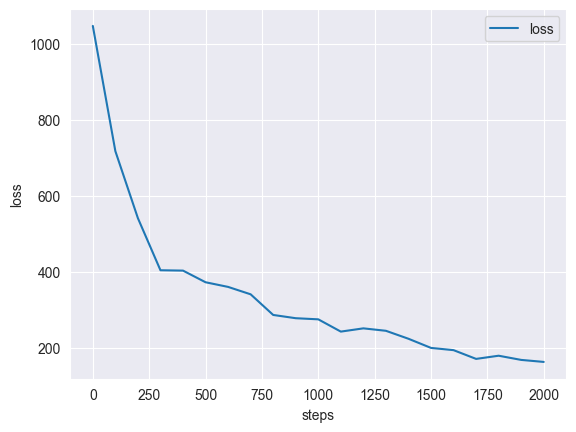

In [10]:
steps = np.asarray(steps)
losses = np.asarray(losses)

sns.set_style('darkgrid')
sns.lineplot(x=steps, y=losses, label='loss')
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()